# Additional dataset: Beijing PM2.5

##  Preparing the datasets


### Load the Data

In [18]:
import pandas as pd

columns = [
    "ID", "Year", "Month", "Day", "Hour", 
    "Dew_Point", "Temperature", "Pressure", 
    "Wind_Direction", "Wind_Speed", 
    "Hours_Snow", "Hours_Rain", "PM2.5"
]

file_path = "data/PRSA_data_2010.1.1-2014.12.31.csv" 
data = pd.read_csv(file_path, header=None, names=columns)

# Preview 
print(data.head())


   ID  Year  Month  Day  Hour Dew_Point Temperature Pressure Wind_Direction  \
0  No  year  month  day  hour     pm2.5        DEWP     TEMP           PRES   
1   1  2010      1    1     0       NaN         -21      -11           1021   
2   2  2010      1    1     1       NaN         -21      -12           1020   
3   3  2010      1    1     2       NaN         -21      -11           1019   
4   4  2010      1    1     3       NaN         -21      -14           1019   

  Wind_Speed Hours_Snow Hours_Rain PM2.5  
0       cbwd        Iws         Is    Ir  
1         NW       1.79          0     0  
2         NW       4.92          0     0  
3         NW       6.71          0     0  
4         NW       9.84          0     0  


### Preprocess the Data
Clean Missing Data: Rows with missing values are dropped.
Remove the ID column (not useful for classification).

Encode the PM2.5 column:
- 0-35 (Good) → 0
- 36-75 (Moderate) → 1,
- "76-115 (Unhealthy for Sensitive Groups) → 2
- "116-150 (Unhealthy) → 3
- "151-250 (Very Unhealthy) → 4
- "250+ (Hazardous) → 5

Separate features and labels.

In [19]:
#Clean the data
data_cleaned = data.dropna()

# Remove the ID column (not useful for classification)
data_cleaned = data_cleaned.drop(columns=["ID"])

# Convert PM2.5 column to numeric values
data_cleaned['PM2.5'] = pd.to_numeric(data_cleaned['PM2.5'], errors='coerce')

# Define a function to categorize PM2.5 values into the China PM2.5 scale
def categorize_pm25(value):
    if value <= 75:
        return 0  # Low
    elif value <= 150:
        return 1  # Medium
    else:
        return 2  # High

# Apply categorization
data_cleaned['PM2.5_Scale_Encoded'] = data_cleaned['PM2.5'].apply(categorize_pm25)

# Separate features and labels
features = data_cleaned.drop(columns=["PM2.5", "PM2.5_Scale_Encoded"]).values  # Features
labels = data_cleaned["PM2.5_Scale_Encoded"]  # Labels


### Shuffle and Split the Dataset

In [20]:
from sklearn.model_selection import train_test_split

# Splits and stratification
proportions = [40, 60, 80, 90]
splits = {}
for prop in proportions:
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, train_size=prop/100, stratify=labels, random_state=42
    )
    splits[f"{int(prop)}_{int(100-prop)}"] = (X_train, X_test, y_train, y_test)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

### Visualize Class Distributions

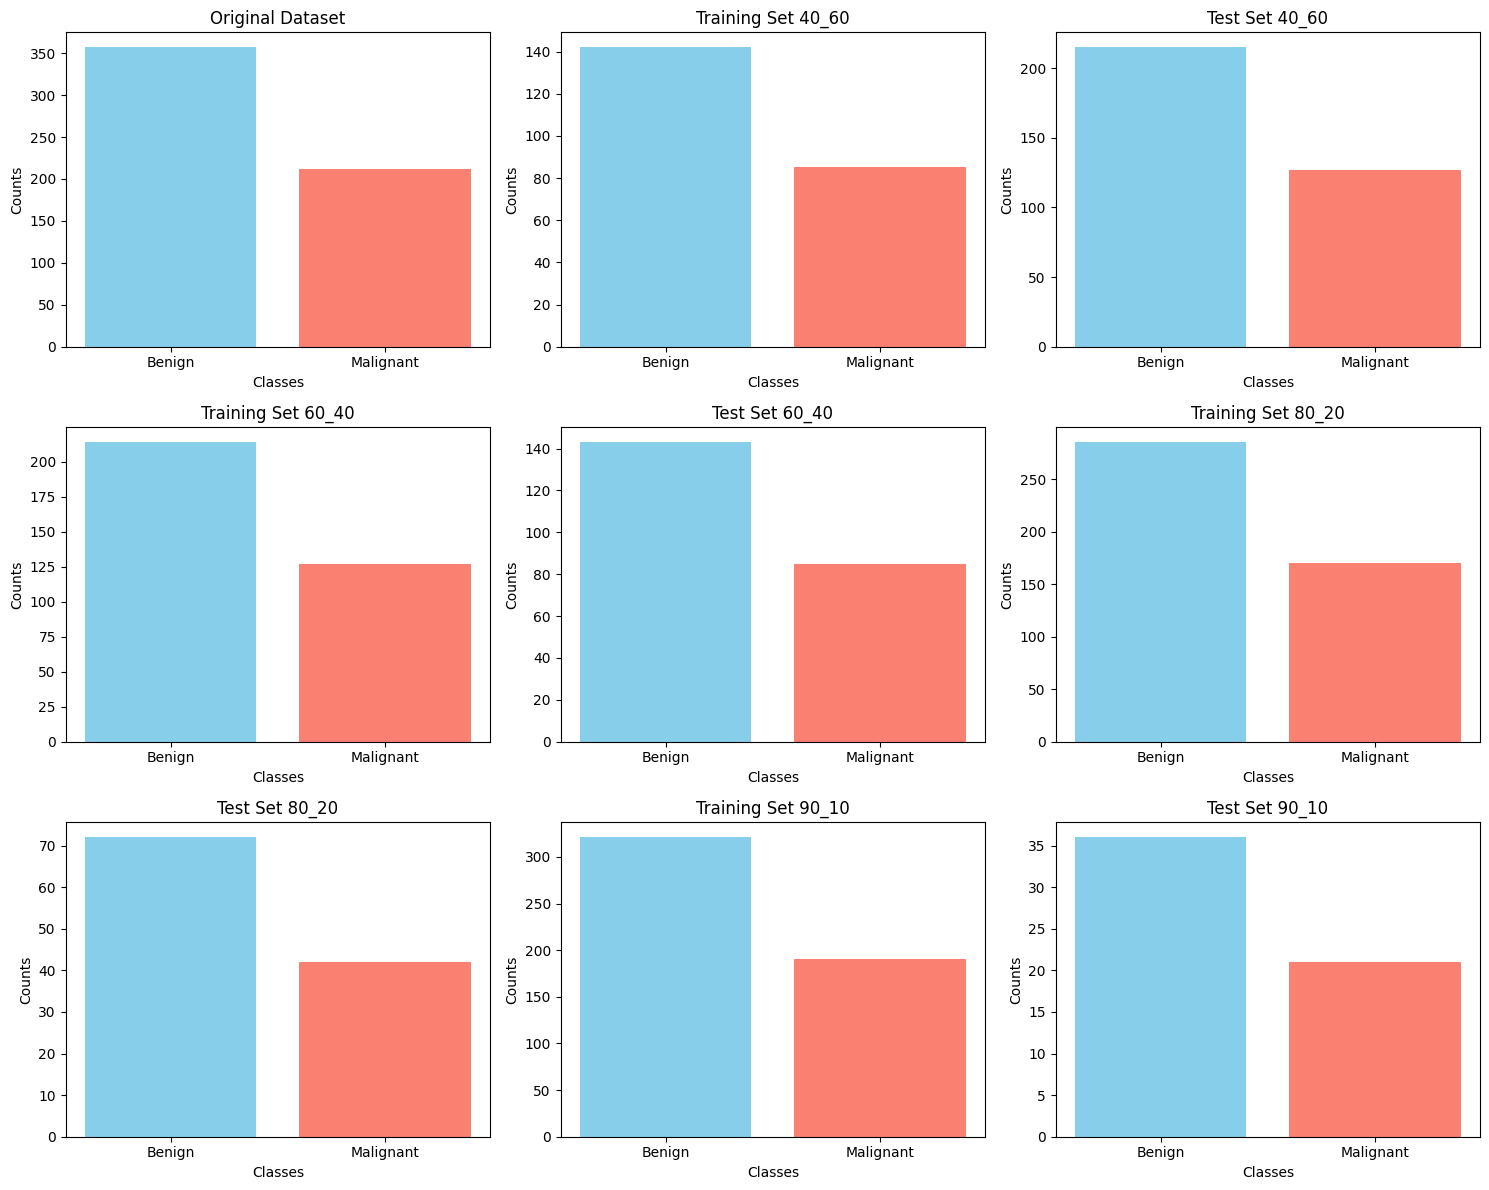

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(ax, title, data_labels):
    unique, counts = np.unique(data_labels, return_counts=True)
    ax.bar(["Benign", "Malignant"], counts, color=["skyblue", "salmon"])
    ax.set_title(title)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Counts")

# Number of splits
num_splits = len(splits)
total_plots = 1 + num_splits * 2  # Original + training + test sets
rows = (total_plots + 2) // 3  
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

# original dataset
plot_distribution(axes[0], "Original Dataset", labels)

# each split
plot_idx = 1
for key, (X_train, X_test, y_train, y_test) in splits.items():
    plot_distribution(axes[plot_idx], f"Training Set {key}", y_train)
    plot_idx += 1
    plot_distribution(axes[plot_idx], f"Test Set {key}", y_test)
    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## Building the decision tree classifiers

Decision Tree Graph for Split 40_60:


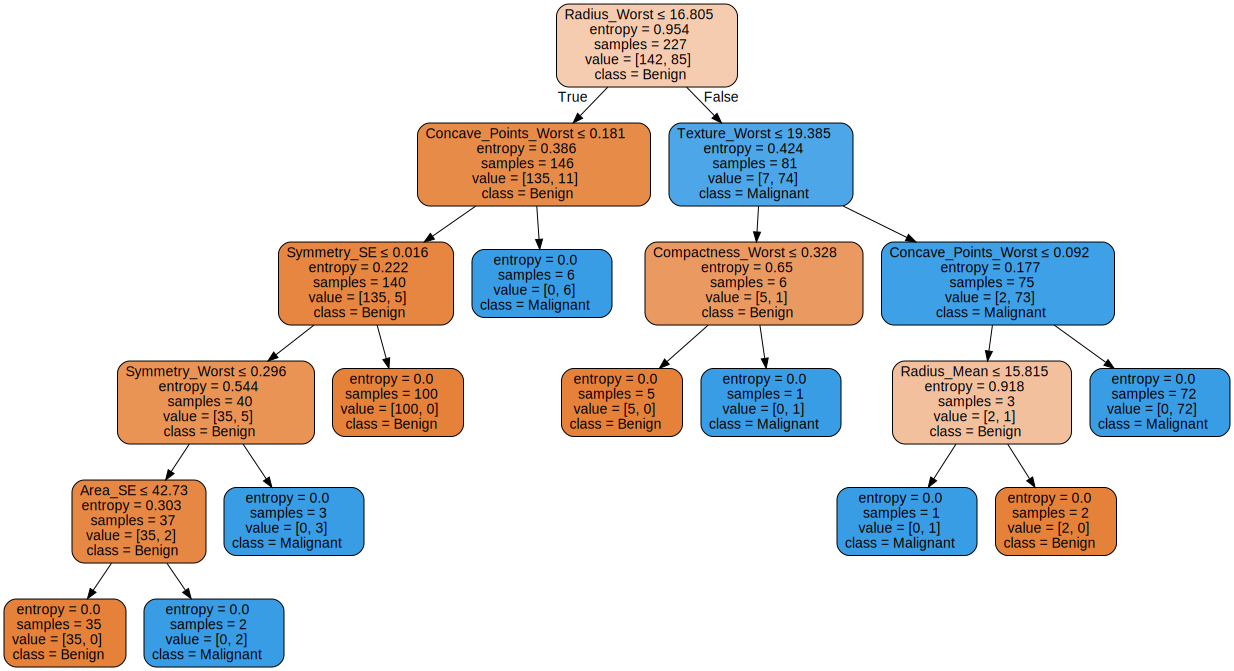

Classification Report for Split 40_60:
              precision    recall  f1-score   support

      Benign       0.91      0.96      0.93       215
   Malignant       0.92      0.83      0.88       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342



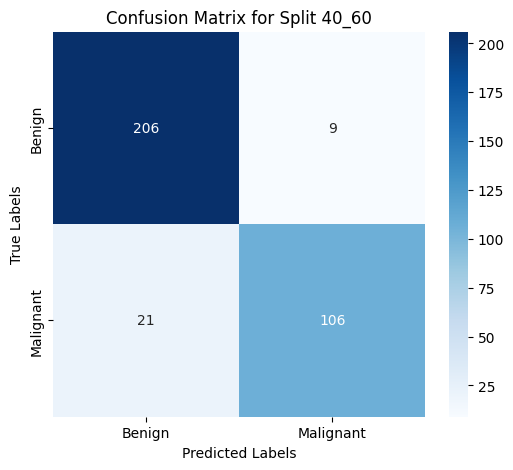

Decision Tree Graph for Split 60_40:


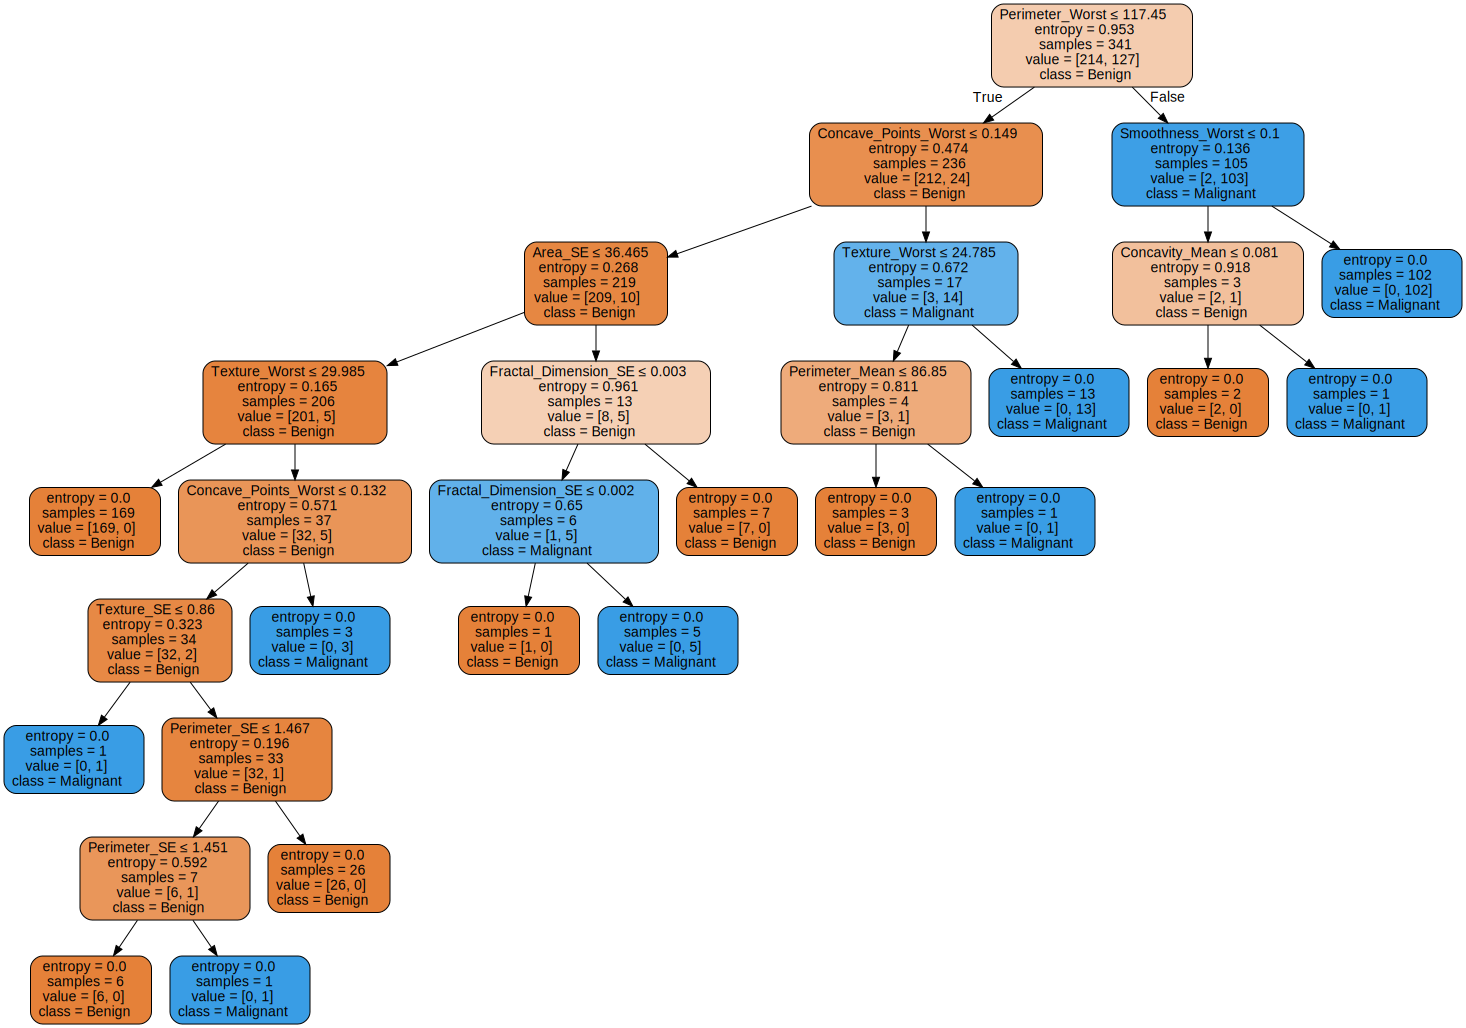

Classification Report for Split 60_40:
              precision    recall  f1-score   support

      Benign       0.94      0.96      0.95       143
   Malignant       0.93      0.91      0.92        85

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228



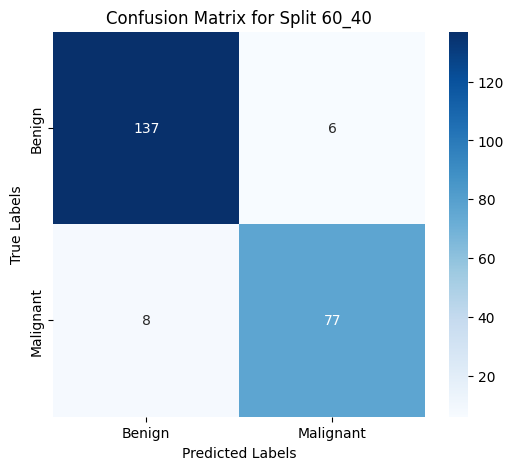

Decision Tree Graph for Split 80_20:


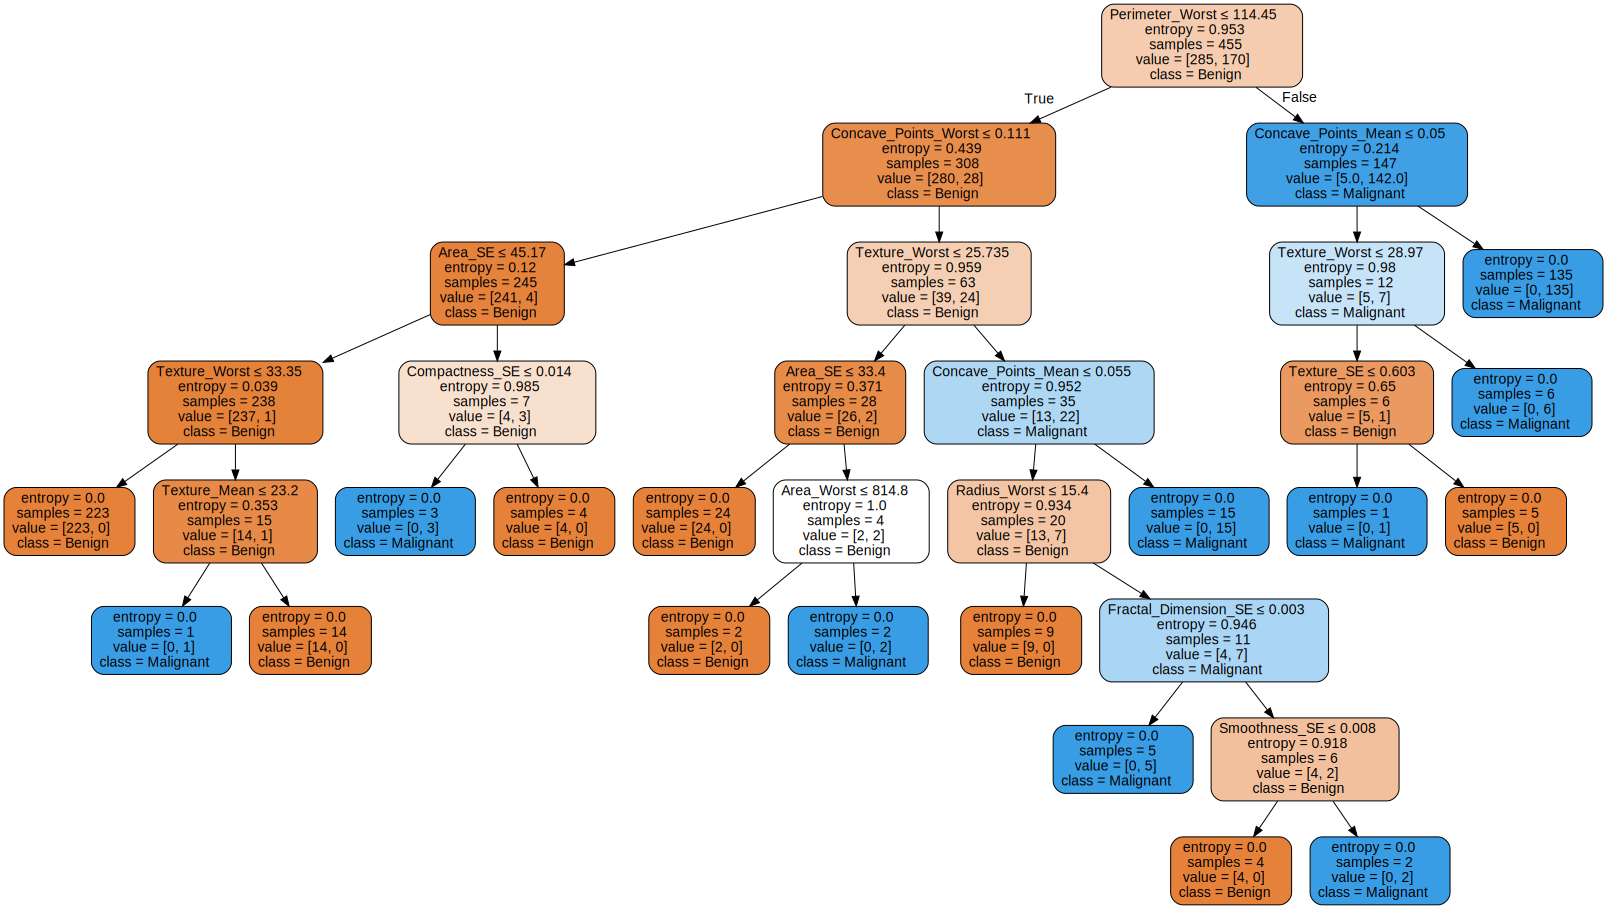

Classification Report for Split 80_20:
              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97        72
   Malignant       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



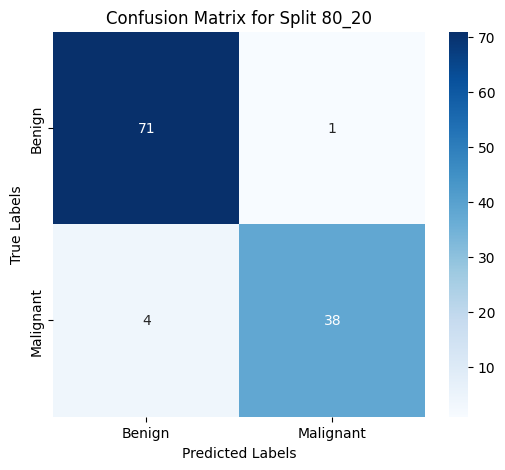

Decision Tree Graph for Split 90_10:


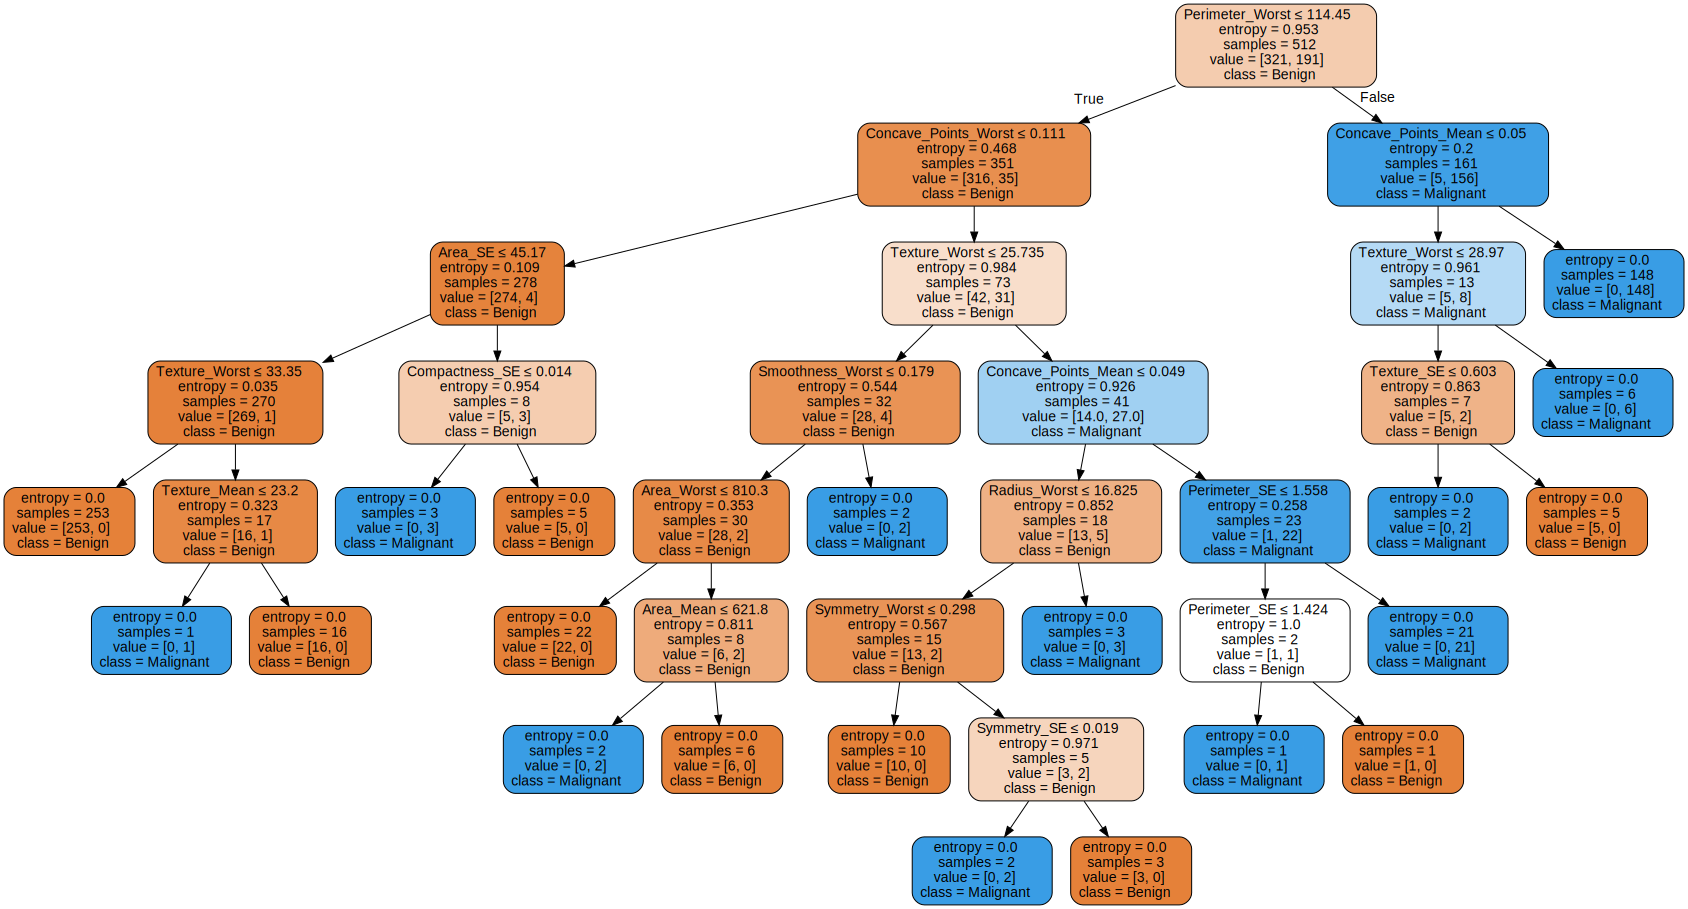

Classification Report for Split 90_10:
              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96        36
   Malignant       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57



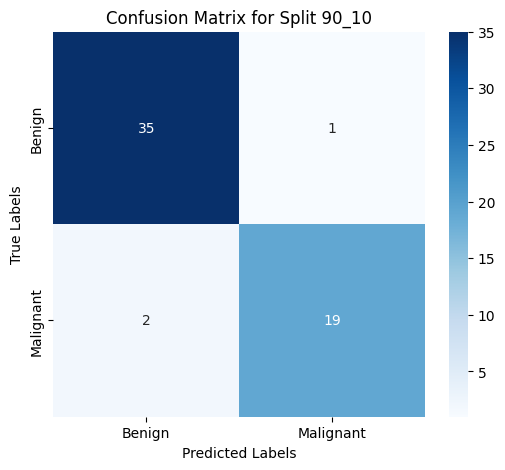

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for key, (X_train, X_test, y_train, y_test) in splits.items():
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    
    # export
    dot_data = export_graphviz(
        clf, 
        out_file=None,  
        feature_names=data.drop(columns=["Diagnosis"]).columns, 
        class_names=["Benign", "Malignant"],  
        filled=True,  
        rounded=True,  
        special_characters=True
    )
    

    graph = graphviz.Source(dot_data)
    graph.render(f"plots/dataset1/decision_tree_{key}", format="png") 
    #view graph
    print(f"Decision Tree Graph for Split {key}:")
    display(graph)

    # classification report
    y_pred = clf.predict(X_test)
    print(f"Classification Report for Split {key}:")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.title(f"Confusion Matrix for Split {key}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()



In [ ]:
%%script echo skipping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a figure for the confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust grid size as needed
fig.suptitle("Confusion Matrices for All Splits", fontsize=16)

# Train and evaluate decision trees for all splits
for i, (key, (X_train, X_test, y_train, y_test)) in enumerate(splits.items()):
    # Train the decision tree classifier using information gain (entropy)
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Generate and print classification report
    print(f"Classification Report for Split {key}:")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix in a subplot
    ax = axes[i // 2, i % 2]  # Determine subplot position
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"],
        ax=ax
    )
    ax.set_title(f"Split {key}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Reserve space for the main title
plt.show()


skipping


## The depth and accuracy of a decision tree

Decision Tree Graph for Max Depth None:


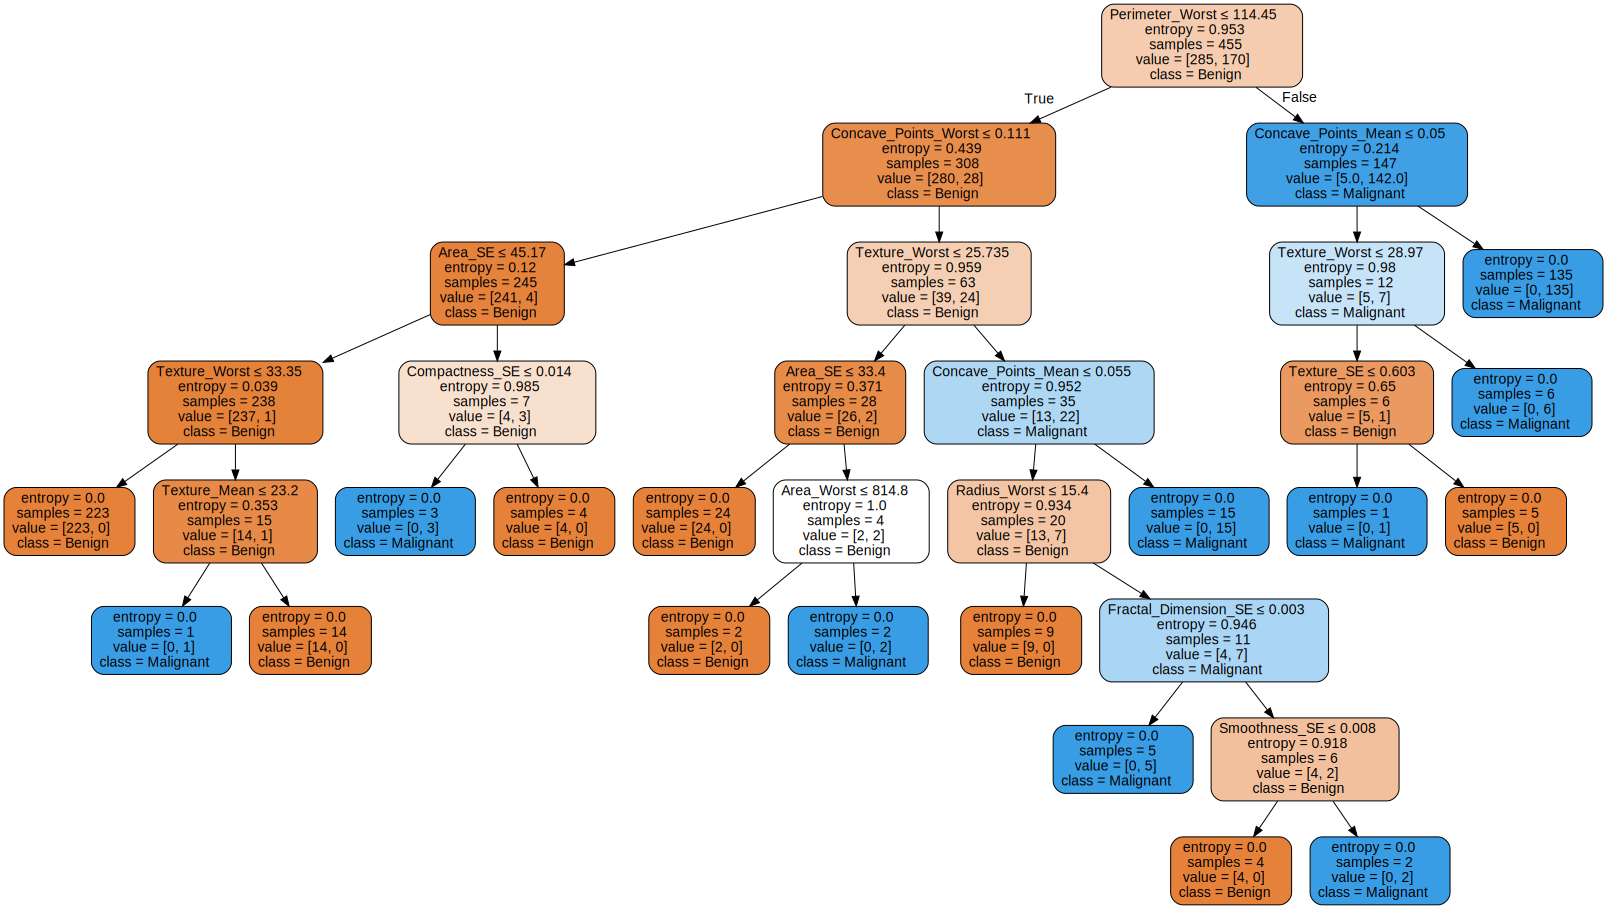

Decision Tree Graph for Max Depth 2:


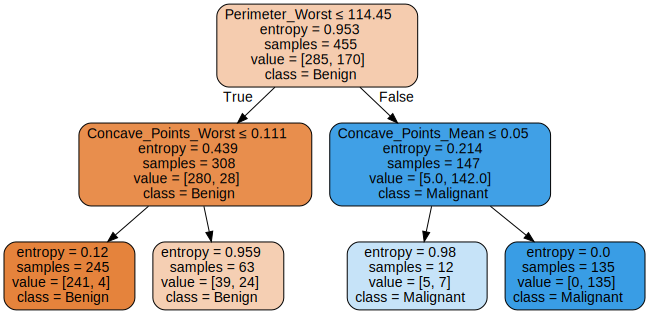

Decision Tree Graph for Max Depth 3:


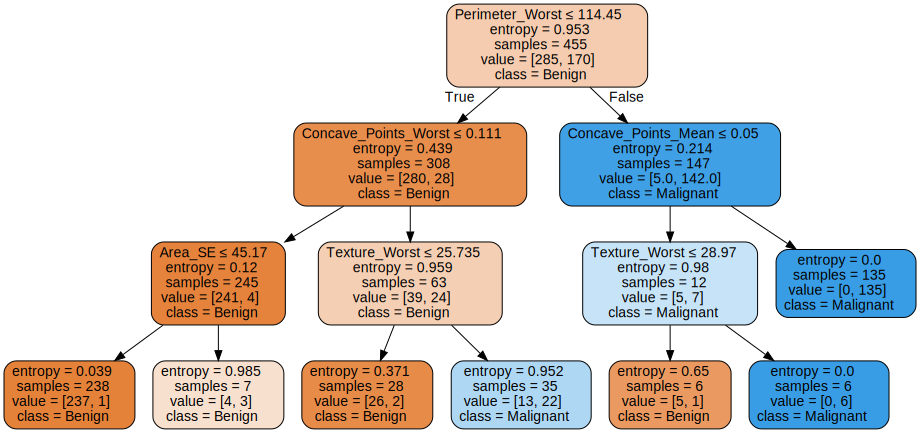

Decision Tree Graph for Max Depth 4:


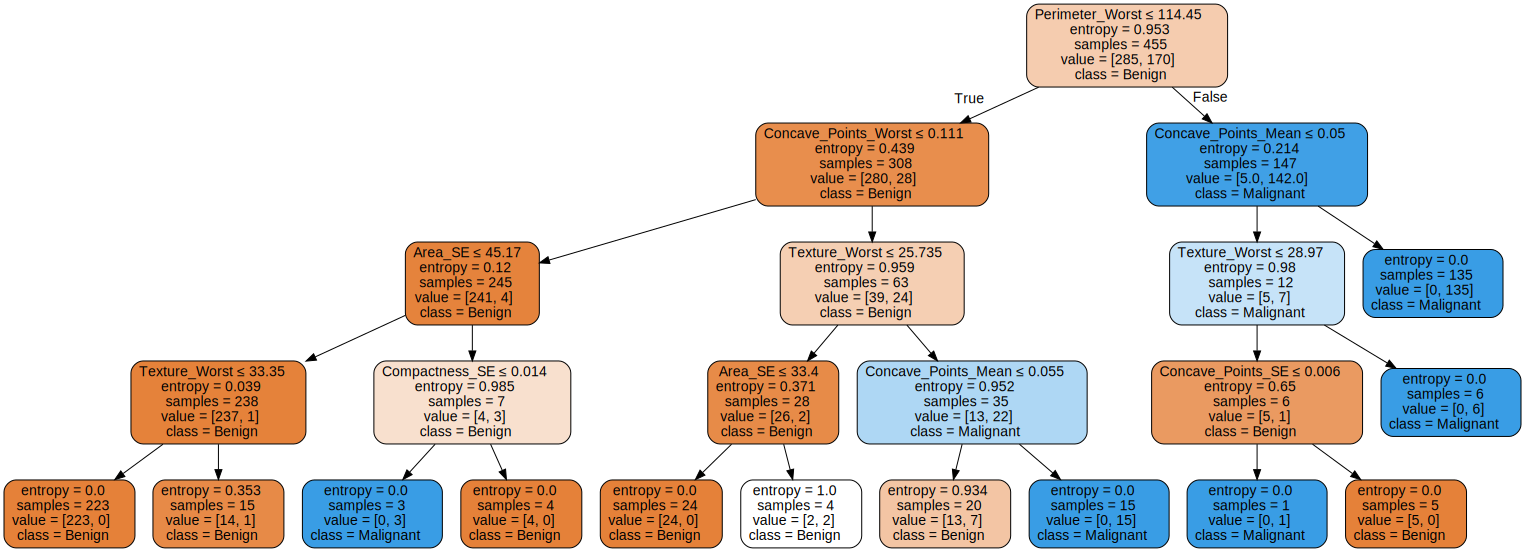

Decision Tree Graph for Max Depth 5:


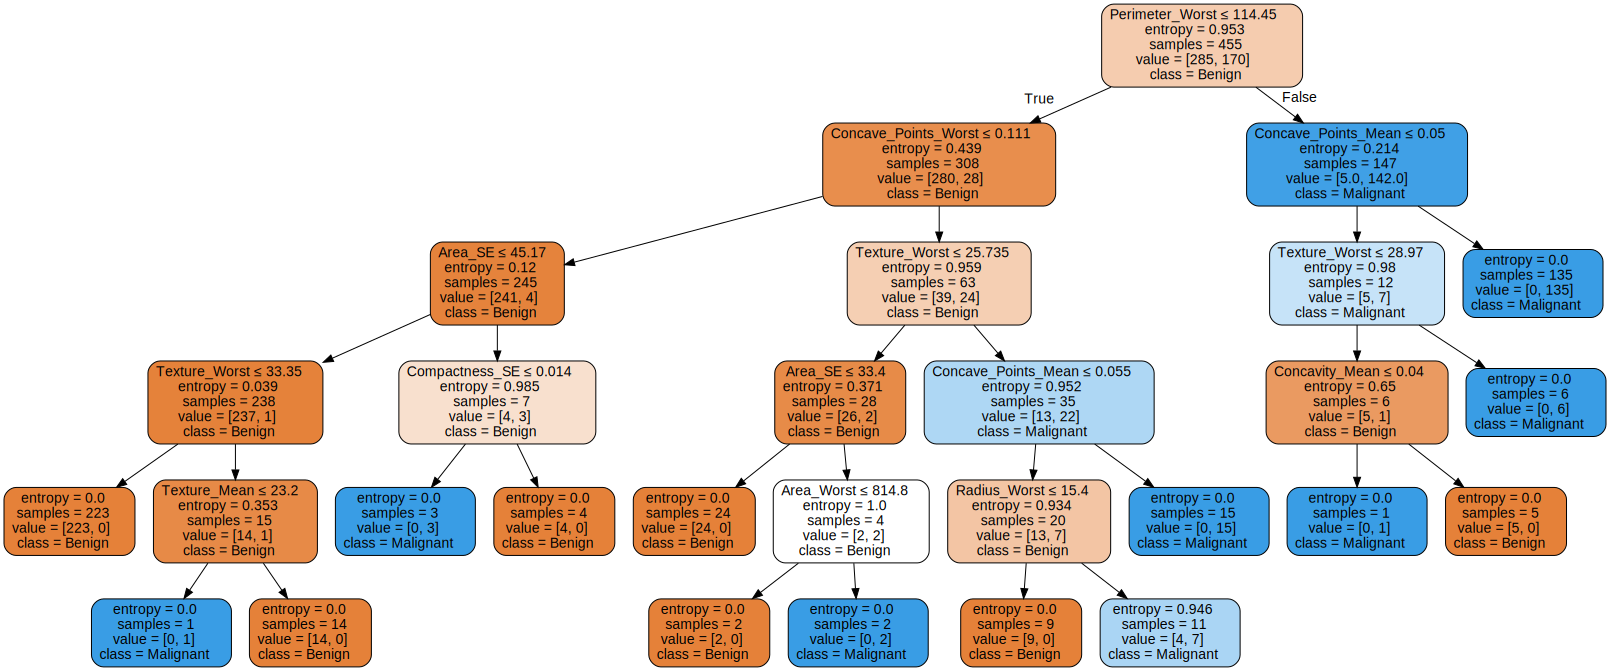

Decision Tree Graph for Max Depth 6:


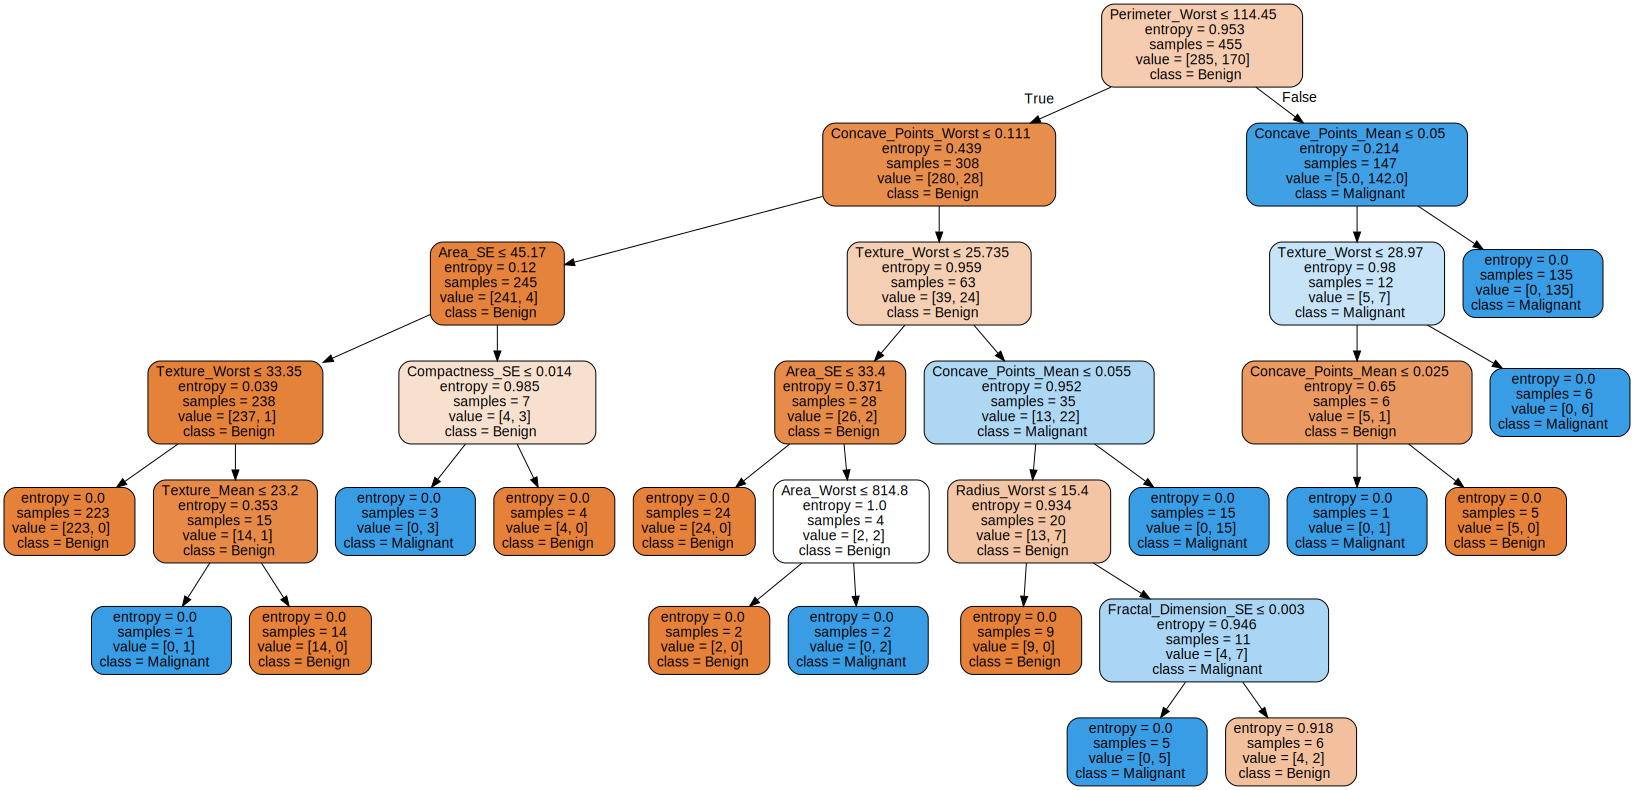

Decision Tree Graph for Max Depth 7:


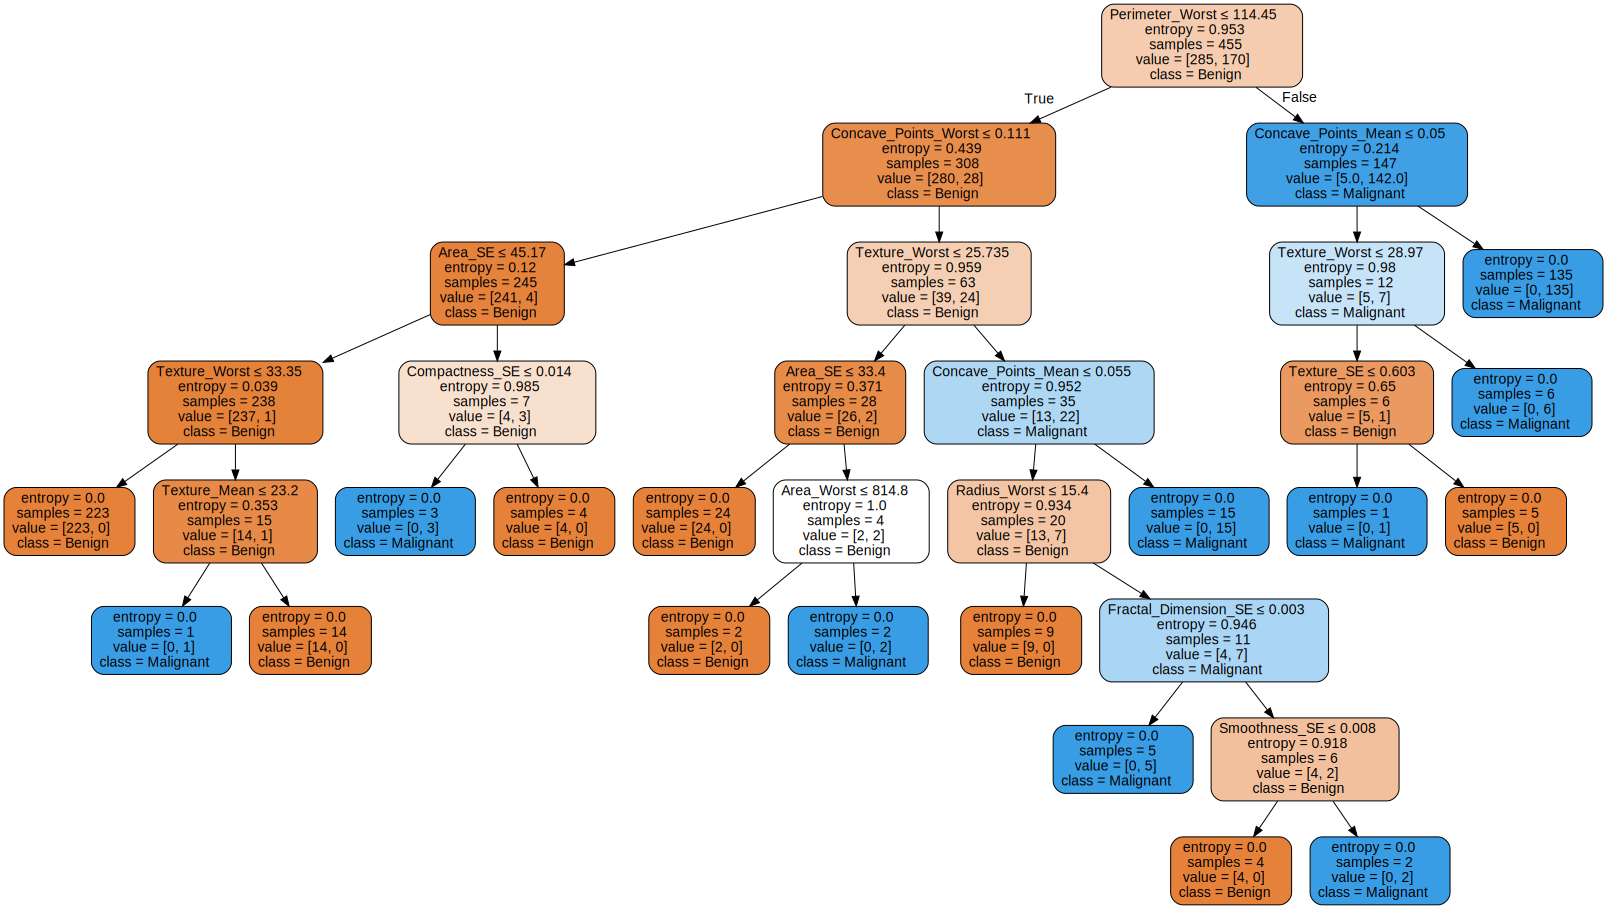

Max Depth Accuracy
None      0.9561
2         0.8860
3         0.9386
4         0.9298
5         0.9561
6         0.9298
7         0.9561


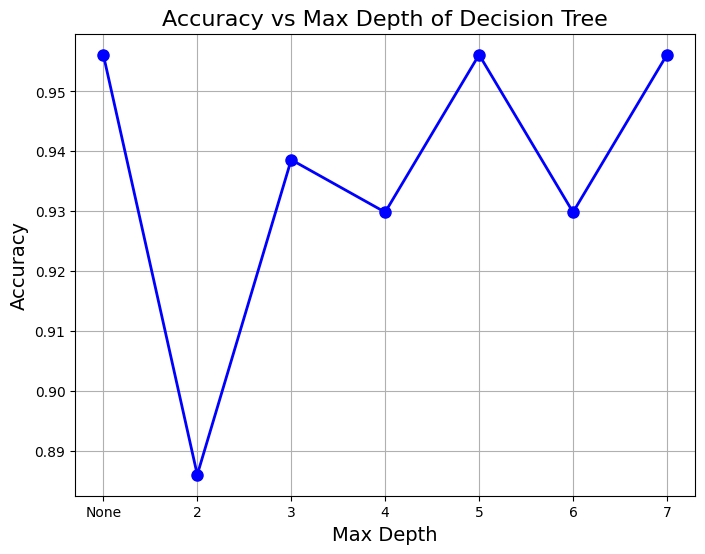

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

# Train and evaluate decision trees for max_depth values: None, 2, 3, 4, 5, 6, 7
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_scores = []

# Prepare data (use 80/20 split)
X_train, X_test, y_train, y_test = splits["80_20"]

for max_depth in max_depth_values:
    # Train the decision tree classifier with the specified max_depth
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    # Export the tree to Graphviz format
    dot_data = export_graphviz(
        clf, 
        out_file=None,  # Output to string (DOT format)
        feature_names=data.drop(columns=["Diagnosis"]).columns,  # Feature names
        class_names=["Benign", "Malignant"],  # Target classes
        filled=True,  # Colorize nodes
        rounded=True,  # Rounded corners
        special_characters=True
    )


    graph = graphviz.Source(dot_data)
    graph.render(f"plots/dataset1/decision_tree_max_depth_{max_depth}", format="png") 
    print(f"Decision Tree Graph for Max Depth {max_depth}:")
    display(graph)

# Report the accuracy scores in a formatted table
print(f"{'Max Depth':<10}{'Accuracy'}")
for depth, accuracy in zip(max_depth_values, accuracy_scores):
    depth_str = "None" if depth is None else depth
    print(f"{depth_str:<10}{accuracy:.4f}")

# Plot the accuracy vs max_depth
plt.figure(figsize=(8, 6))
plt.plot([str(d) if d is not None else "None" for d in max_depth_values], accuracy_scores, 
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title("Accuracy vs Max Depth of Decision Tree", fontsize=16)
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.show()